# Evaluating Machine Learning Models for Gene Expression Analysis in AML and ALL Cancer Classification and Clustering


## Machine Learning Project
## Wina Munada - AIU221063

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import all the necessary library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set_theme(style="darkgrid")
np.random.seed(42)

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
le = LabelEncoder()

### Load data

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/gene-expression/data_set_ALL_AML_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/gene-expression/data_set_ALL_AML_independent.csv")
labels = pd.read_csv("/content/drive/MyDrive/gene-expression/actual.csv", index_col = 'patient')

In [ ]:
train_data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
test_data.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


### Check NAs

In [ ]:
print(train_data.isna().sum().sum())
print(test_data.isna().sum().sum())

0
0


## EDA and data preprocessing

It seems like **call** columns have "A" almost everywhere, so I will drop it.

In [ ]:
cols_train = [col for col in train_data.columns if "call" in col]
cols_test = [col for col in test_data.columns if "call" in col]

train_data.drop(cols_train, axis=1, inplace=True)
test_data.drop(cols_test, axis=1, inplace=True)

Here we have features in rows and patients in cols, so we need to transpose data.

In [ ]:
train_data = train_data.T
test_data = test_data.T

In [ ]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [ ]:
train_data.columns = test_data.iloc[1].values
train_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)
test_data.columns = test_data.iloc[1].values
test_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)

In [ ]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [ ]:
# Adding new column
train_data["patient"] = train_data.index.values
test_data["patient"] = test_data.index.values

In [ ]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5


In [ ]:
train_data = train_data.astype("int32")
test_data = test_data.astype("int32")

In [ ]:
labels["cancer"] = le.fit_transform(labels["cancer"])
train_data = pd.merge(train_data, labels, on="patient")
test_data = pd.merge(test_data, labels, on="patient")

In [ ]:
train_data["cancer"].value_counts()

cancer
0    27
1    11
Name: count, dtype: int64

In [ ]:
test_data["cancer"].value_counts()

cancer
0    20
1    14
Name: count, dtype: int64

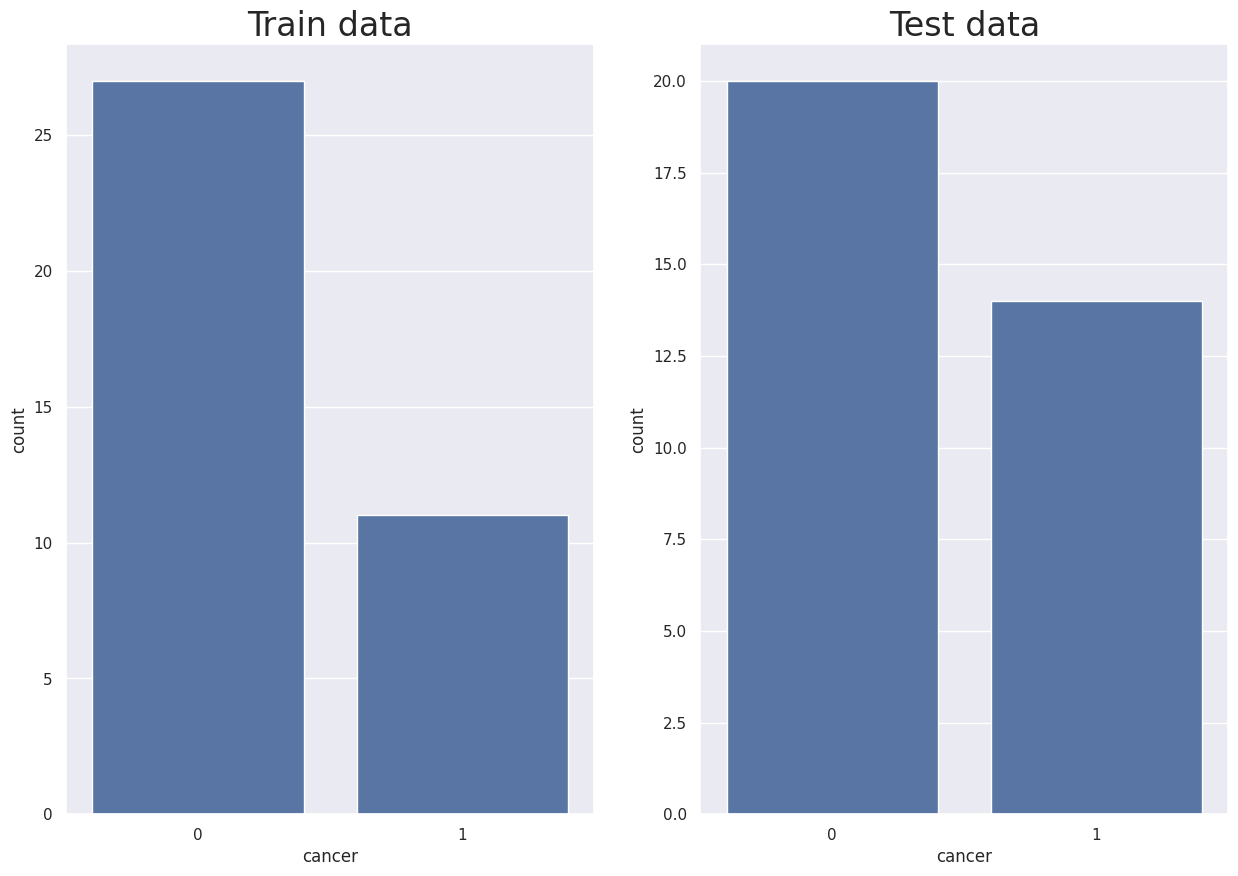

In [ ]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
plt.show()

In test data we have $\frac{ALL}{AML}$ ratio about $\frac{20}{14}=1.43$ and in train $\frac{27}{11}=2.45$. Lets use upsampling to combat class imbalance. I think here we can add about 8 additional random samples of **AML** class.

In [ ]:
upsampled_data = random.sample(train_data.query("cancer == 1")["patient"].index.to_list(), k=8, )

In [ ]:
upsampled_data

[28, 27, 30, 31, 32, 33, 36, 29]

In [ ]:
train_data_upsampled = pd.concat([train_data, train_data.iloc[upsampled_data, :]])

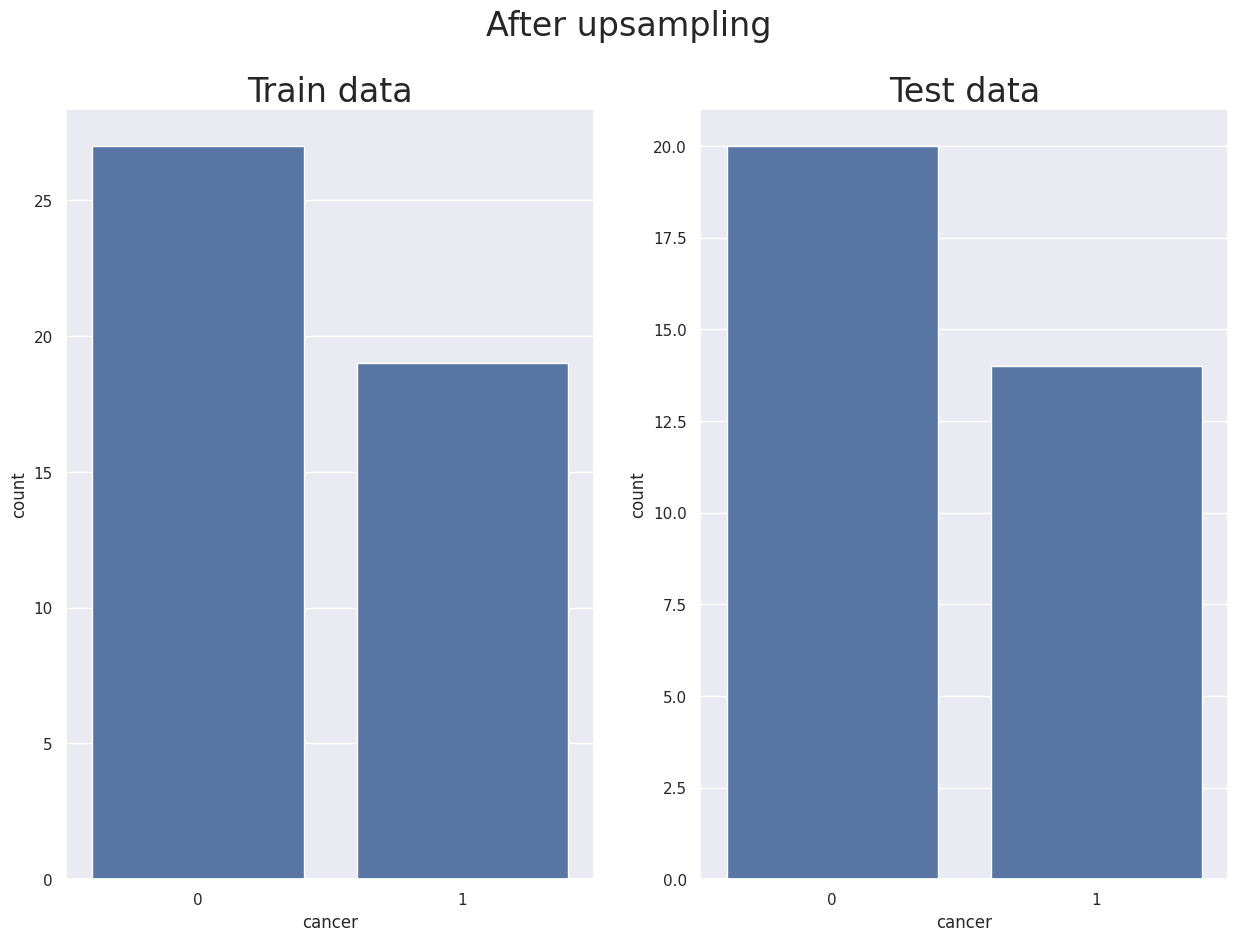

In [ ]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data_upsampled, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
fig.suptitle("After upsampling", fontsize=24)
plt.show()

Scaling the data.

In [ ]:
X_train = train_data_upsampled.drop(columns=["patient", "cancer"])
y_train = train_data_upsampled["cancer"]
X_test = test_data.drop(columns=["patient", "cancer"])
y_test = test_data["cancer"]

In [ ]:
# Features scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## Dimentionality reduction and clusterisation

In [ ]:
# PCA transformation to reduce the dimensionality
pca = PCA(n_components=2)
reduced_train = pca.fit_transform(X_train_scaled)
reduced_test = pca.transform(X_test_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans.fit(reduced_train)


KMeans(n_clusters=2, n_init=20, random_state=42)

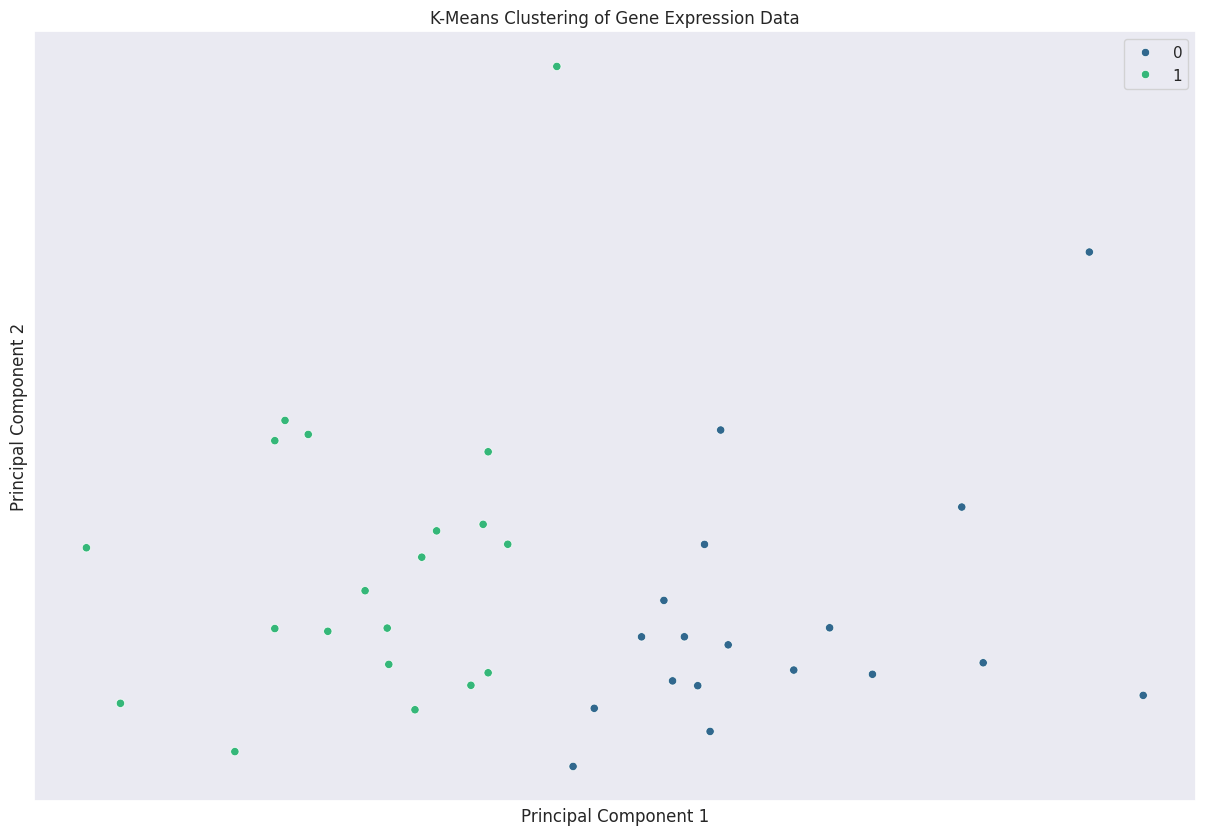

In [ ]:
# Plotting the clusters
sns.scatterplot(x=reduced_train[:, 0], y=reduced_train[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('K-Means Clustering of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Evaluate the performance
y_pred_kmeans = kmeans.predict(reduced_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_kmeans)
f1 = f1_score(y_test, y_pred_kmeans)
recall = recall_score(y_test, y_pred_kmeans)

print('Validation Accuracy of K-means:', accuracy)
print('Validation F1-score of K-means:', f1)
print('Validation Recall of K-means:', recall)
print("\nClassification report :\n", metrics.classification_report(y_test, y_pred_kmeans))

Validation Accuracy of K-means: 0.29411764705882354
Validation F1-score of K-means: 0.33333333333333326
Validation Recall of K-means: 0.42857142857142855

Classification report :
               precision    recall  f1-score   support

           0       0.33      0.20      0.25        20
           1       0.27      0.43      0.33        14

    accuracy                           0.29        34
   macro avg       0.30      0.31      0.29        34
weighted avg       0.31      0.29      0.28        34



27 features explain around 90% of the variance. From 7129 features to 27


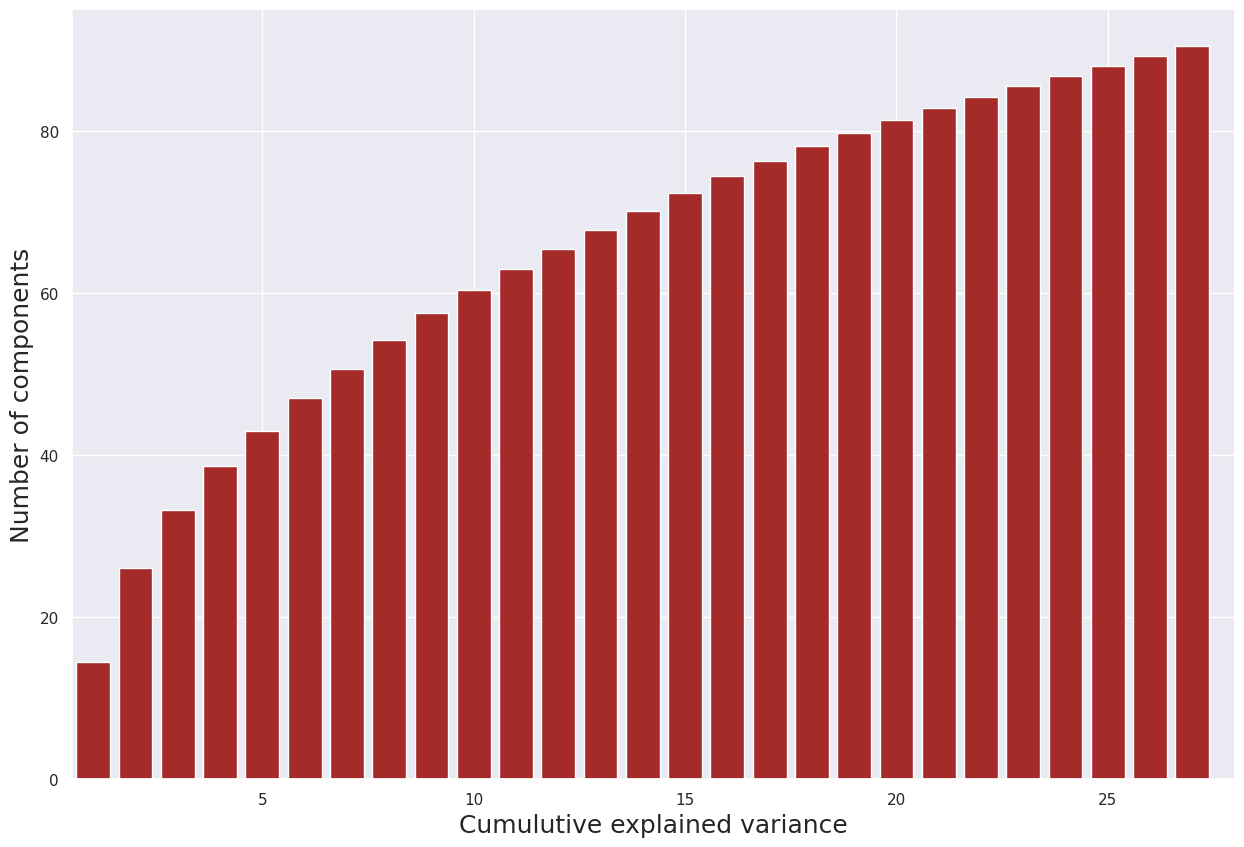

In [ ]:
pca = PCA()
pca.fit_transform(X_train_scaled)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
print(k, " features explain around 90% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(1, k + 1), var_exp, color="brown")
plt.xlabel("Cumulutive explained variance", fontsize=18)
plt.ylabel("Number of components", fontsize=18)
plt.xlim((0.5, k + 1))
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for reducing dimensionality
pca = PCA(n_components=2)
reduced_train = pca.fit_transform(X_train_scaled)
reduced_test = pca.transform(X_test_scaled)

# Hyperparameter tuning for K-means
best_accuracy = 0
best_params = {}
for n_clusters in range(2, 10):
    for n_init in [10, 20, 30]:
        for max_iter in [300, 400, 500]:
            kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, random_state=42)
            kmeans.fit(reduced_train)
            y_pred_kmeans = kmeans.predict(reduced_test)

            # Adjust labels to match the true labels
            y_pred_kmeans_adjusted = np.where(y_pred_kmeans == 0, 1, 0)

            accuracy = accuracy_score(y_test, y_pred_kmeans_adjusted)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_clusters': n_clusters, 'n_init': n_init, 'max_iter': max_iter}

In [ ]:
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'n_clusters': 2, 'n_init': 10, 'max_iter': 300}
Best Accuracy: 0.7058823529411765


In [ ]:
# Train with best parameters
kmeans = KMeans(**best_params, random_state=42)
kmeans.fit(reduced_train)

# Predict and evaluate the performance
y_pred_kmeans = kmeans.predict(reduced_test)

# Adjust labels to match the true labels if necessary
# Uncomment and adjust the next line if your initial label mapping is incorrect
y_pred_kmeans = np.where(y_pred_kmeans == 0, 1, 0)

In [ ]:

accuracy = accuracy_score(y_test, y_pred_kmeans)
f1 = f1_score(y_test, y_pred_kmeans)
recall = recall_score(y_test, y_pred_kmeans)

print('Validation Accuracy of K-means:', accuracy)
print('Validation F1-score of K-means:', f1)
print('Validation Recall of K-means:', recall)


Validation Accuracy of K-means: 0.7058823529411765
Validation F1-score of K-means: 0.6153846153846153
Validation Recall of K-means: 0.5714285714285714


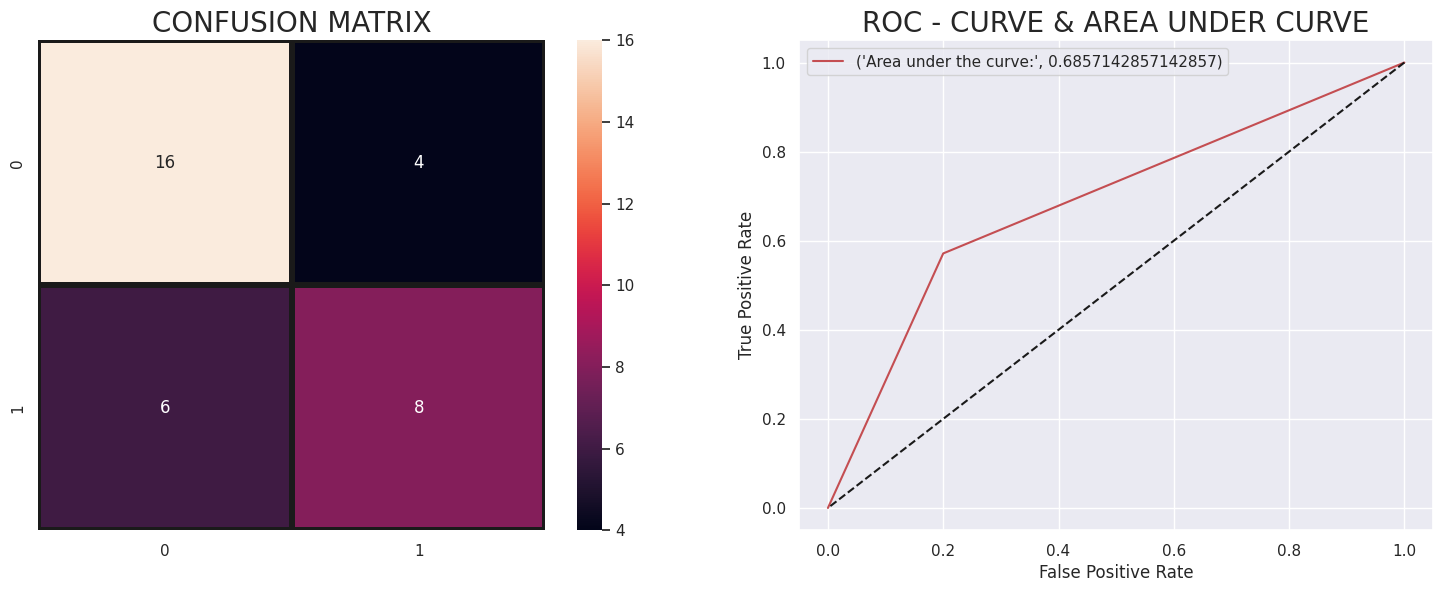

In [ ]:
# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_kmeans), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_kmeans)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", metrics.auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()

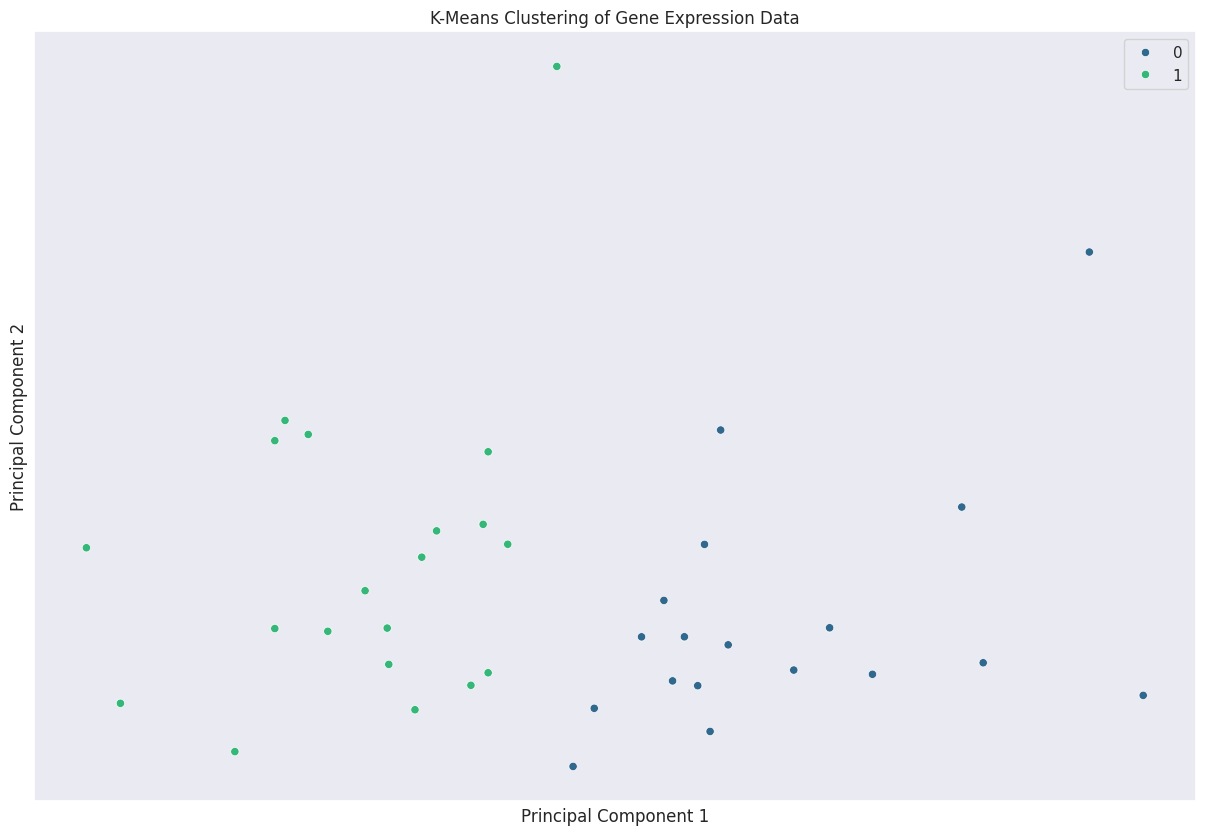

In [ ]:
# Plotting the clusters
sns.scatterplot(x=reduced_train[:, 0], y=reduced_train[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('K-Means Clustering of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(())
plt.yticks(())
plt.show()

#### Also it is interesting to see if hierarchial clusterisation give us 2 clusters based on cancer type.

In [ ]:
cancer_labels = train_data_upsampled["cancer"].map({0: le.classes_[0], 1: le.classes_[1]}).values
patient_labels = np.array(list(map(str, train_data_upsampled["patient"].values))).astype("object") + "_" + cancer_labels

#### Hierarchy

In [ ]:
link = linkage(X_train_scaled, 'ward', 'euclidean')

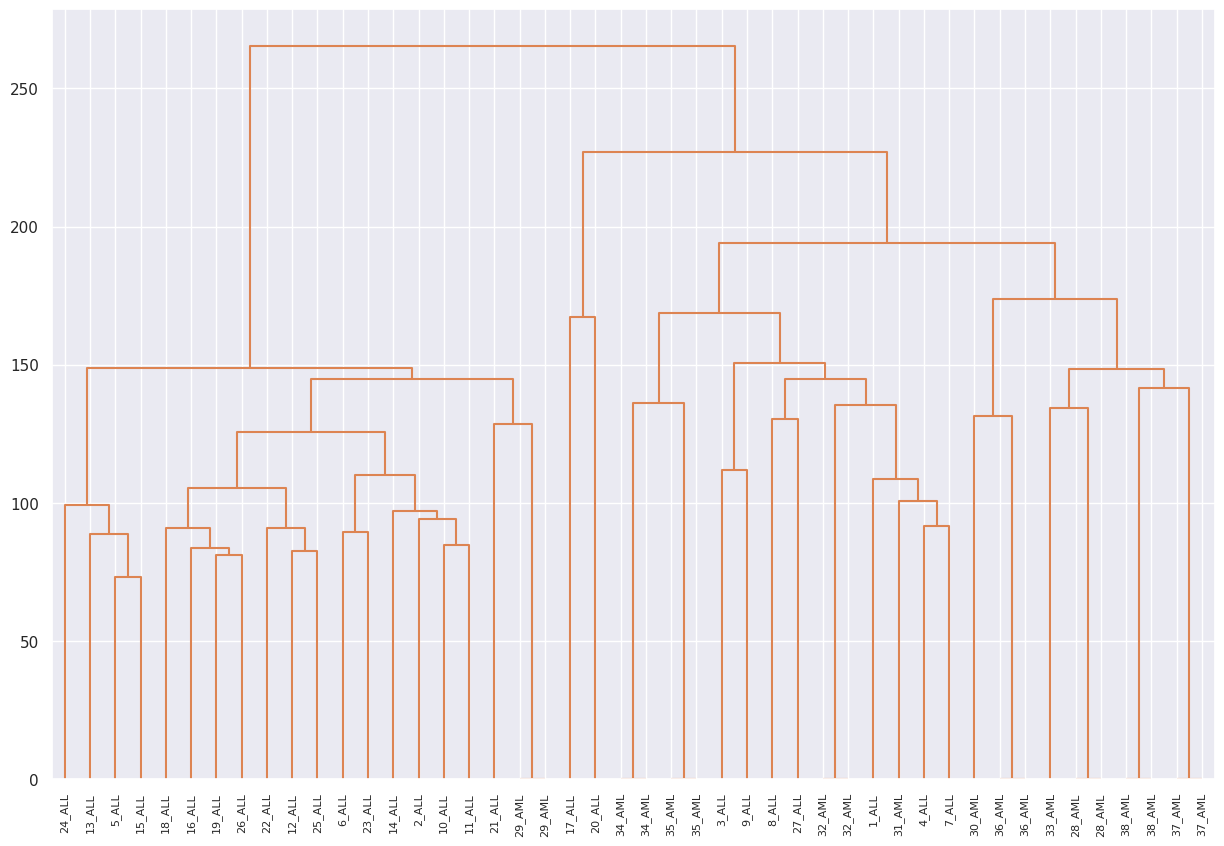

In [ ]:
dm = dendrogram(link, color_threshold=1250, labels=patient_labels)

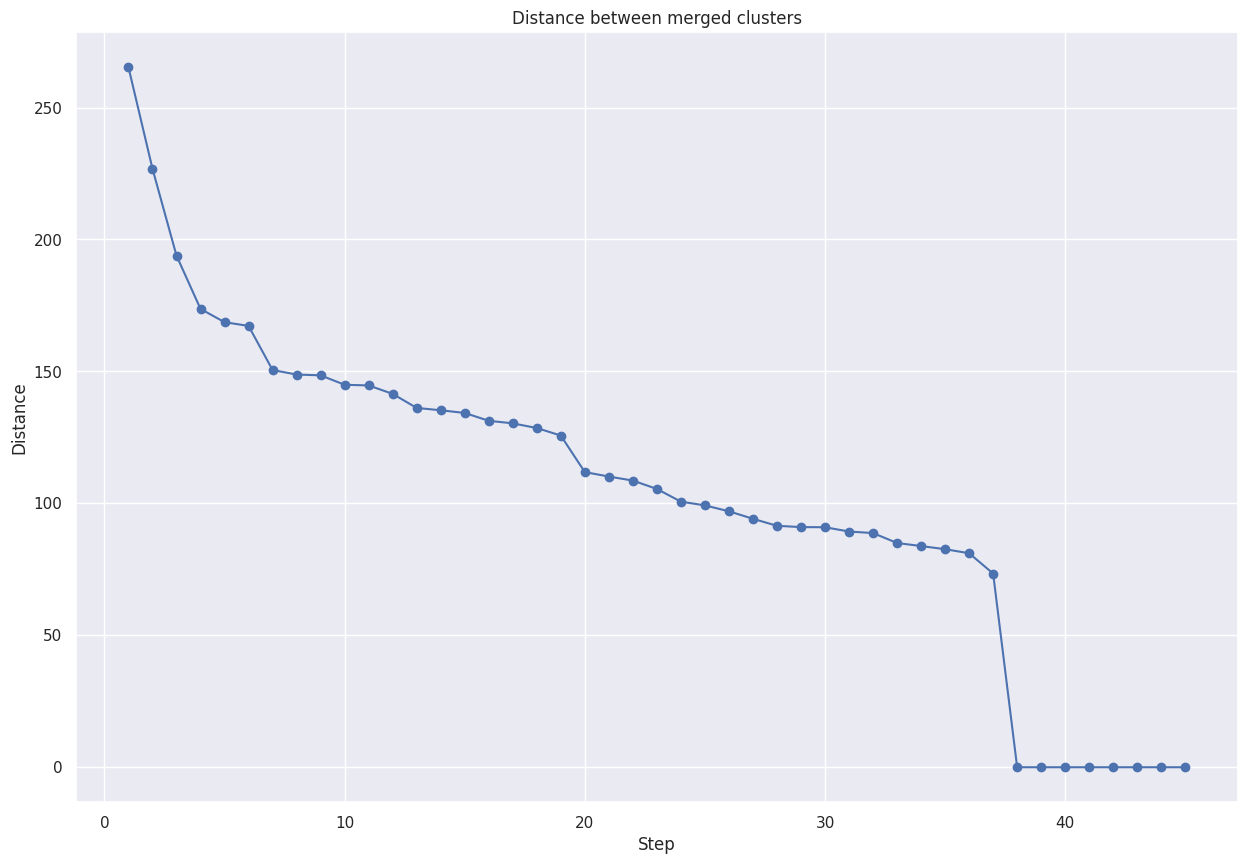

In [ ]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gmm.fit(reduced_train)

# Predicting the clusters
y_pred_gmm_train = gmm.predict(reduced_train)
y_pred_gmm_test = gmm.predict(reduced_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

# Adjust labels to match the true labels if necessary
# Uncomment and adjust the next line if your initial label mapping is incorrect
y_pred_gmm_test = np.where(y_pred_gmm_test == 0, 1, 0)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred_gmm_test)
f1 = f1_score(y_test, y_pred_gmm_test)
recall = recall_score(y_test, y_pred_gmm_test)

print('Validation Accuracy of GMM:', accuracy)
print('Validation F1-score of GMM:', f1)
print('Validation Recall of GMM:', recall)
print("\nClassification report :\n", classification_report(y_test, y_pred_gmm_test))

Validation Accuracy of GMM: 0.4117647058823529
Validation F1-score of GMM: 0.5833333333333334
Validation Recall of GMM: 1.0

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.41      1.00      0.58        14

    accuracy                           0.41        34
   macro avg       0.21      0.50      0.29        34
weighted avg       0.17      0.41      0.24        34



In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

# Assuming you have loaded your data into X_train, X_test, y_train, y_test

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for reducing dimensionality
pca = PCA(n_components=2)
reduced_train = pca.fit_transform(X_train_scaled)
reduced_test = pca.transform(X_test_scaled)

# Hyperparameter tuning for GMM
best_accuracy = 0
best_params = {}
start_time = time()

for n_components in range(2, 10):
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
        for n_init in [10, 20, 30, 50]:
            for max_iter in [300, 400, 500, 1000]:
                gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type,
                                      n_init=n_init, max_iter=max_iter, random_state=42)
                gmm.fit(reduced_train)
                y_pred_gmm_test = gmm.predict(reduced_test)

                # Adjust labels to match the true labels if necessary
                y_pred_gmm_test = np.where(y_pred_gmm_test == 0, 1, 0)

                accuracy = accuracy_score(y_test, y_pred_gmm_test)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'n_components': n_components,
                        'covariance_type': covariance_type,
                        'n_init': n_init,
                        'max_iter': max_iter
                    }

                # Break if time exceeds 5 minutes
                if time() - start_time > 300:
                    break
            if time() - start_time > 300:
                break
        if time() - start_time > 300:
            break
    if time() - start_time > 300:
        break

# Train with best parameters
gmm = GaussianMixture(**best_params, random_state=42)
gmm.fit(reduced_train)

# Predict and evaluate the performance
y_pred_gmm_test = gmm.predict(reduced_test)

# Adjust labels to match the true labels if necessary
y_pred_gmm_test = np.where(y_pred_gmm_test == 0, 1, 0)

accuracy = accuracy_score(y_test, y_pred_gmm_test)
f1 = f1_score(y_test, y_pred_gmm_test)
recall = recall_score(y_test, y_pred_gmm_test)

In [ ]:
print('Best Parameters for GMM:', best_params)
print('Validation Accuracy of GMM:', accuracy)
print('Validation F1-score of GMM:', f1)
print('Validation Recall of GMM:', recall)
print("\nClassification report :\n", classification_report(y_test, y_pred_gmm_test))

Best Parameters for GMM: {'n_components': 3, 'covariance_type': 'full', 'n_init': 10, 'max_iter': 300}
Validation Accuracy of GMM: 0.7352941176470589
Validation F1-score of GMM: 0.6666666666666666
Validation Recall of GMM: 0.6428571428571429

Classification report :
               precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.69      0.64      0.67        14

    accuracy                           0.74        34
   macro avg       0.73      0.72      0.72        34
weighted avg       0.73      0.74      0.73        34




Confusion Matrix:
 [[16  4]
 [ 5  9]]


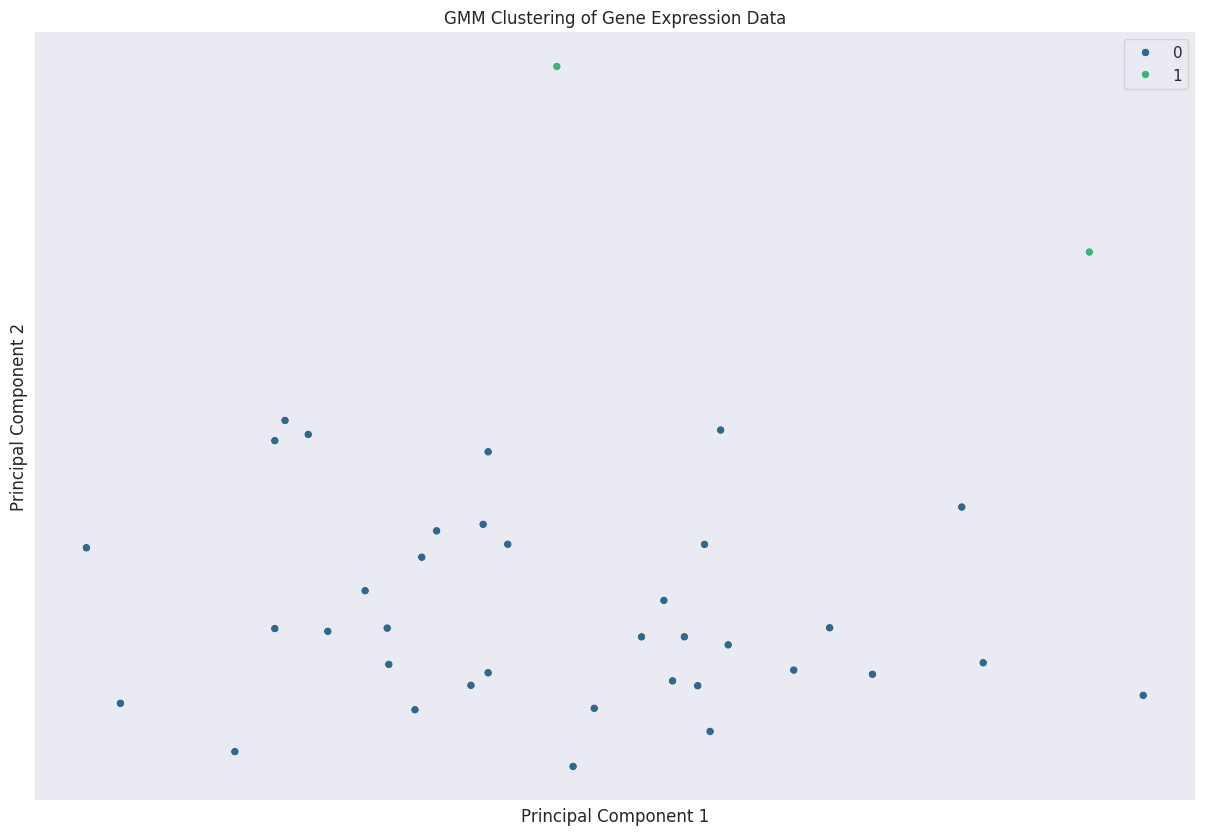

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gmm_test)
print("\nConfusion Matrix:\n", conf_matrix)

# Plotting the clusters
sns.scatterplot(x=reduced_train[:, 0], y=reduced_train[:, 1], hue=y_pred_gmm_train, palette='viridis')
plt.title('GMM Clustering of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(())
plt.yticks(())
plt.show()

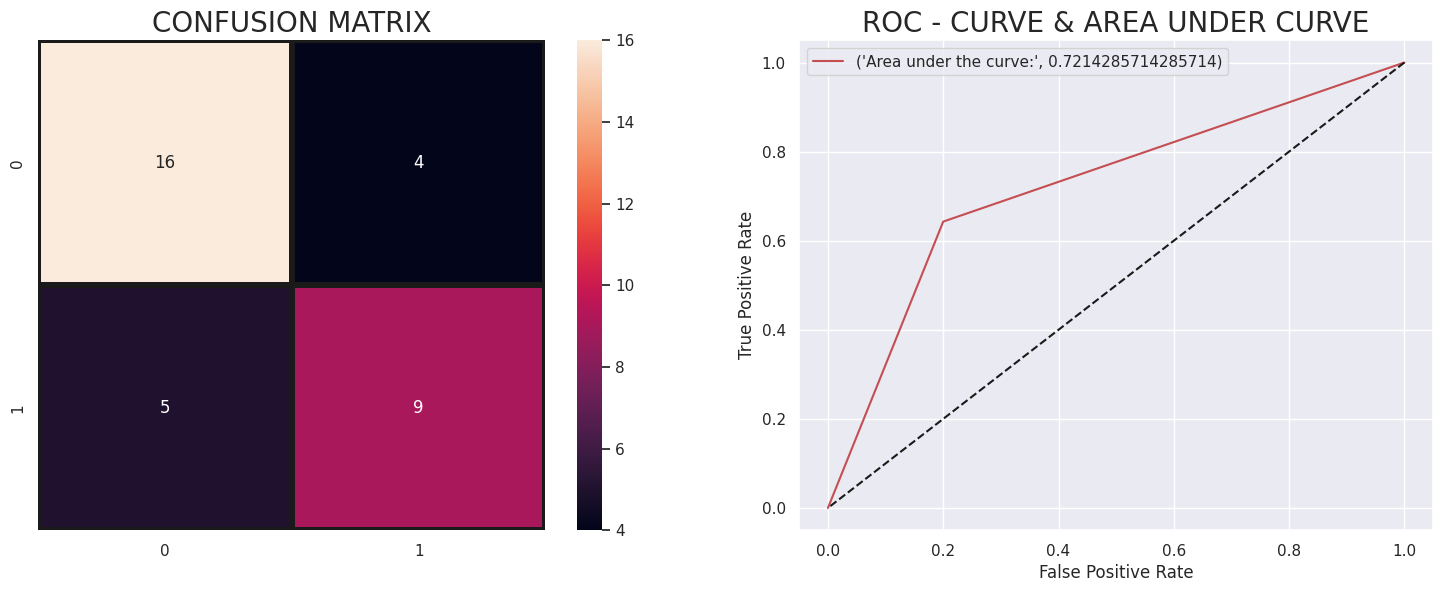

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred_gmm_test), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gmm_test)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()

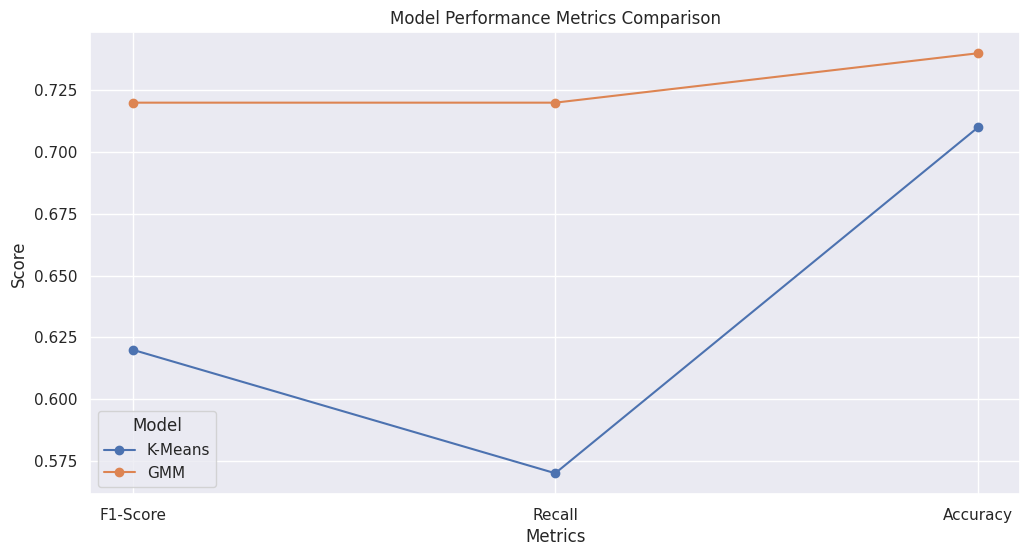

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data for KMeans and GMM
# These are dummy values for demonstration purposes.
# Replace these with the actual values obtained from your evaluation.

metrics = ['F1-Score', 'Recall', 'Accuracy']
kmeans_scores = [0.62, 0.57, 0.71]  # Replace with actual KMeans scores
gmm_scores = [0.72, 0.72, 0.74]     # Replace with actual GMM scores

# Plotting the model performance metrics for comparison
plt.figure(figsize=(12, 6))
plt.plot(metrics, kmeans_scores, marker='o', label='K-Means')
plt.plot(metrics, gmm_scores, marker='o', label='GMM')
plt.title('Model Performance Metrics Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model')
plt.grid(True)
plt.show()
